#### CSC 215 Artificial Intelligence (Spring 2023)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Lab 18:  GradientTape: A brand-new function in TensorFlow 2.0!


With the TensorFlow 2.0 release, we now have the GradientTape function, which makes it easier than ever to write **custom training loops** to support the following: thanks to automatic differentiation.

1. Customize the data batching process
2. Handle multiple inputs and/or outputs with different spatial dimensions
3. Utilize a custom loss function
4. Access gradients for specific layers and update them in a unique manner

**Automatic differentiation** is fast and efficient, and best of all, it can compute **partial derivatives with respect to any inputs** (which is exactly what we need when applying gradient descent to train our models).

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

In [8]:
x = tf.Variable(3.0, trainable=True)

with tf.GradientTape() as t:
    #t.watch(x)
    y = x**2

print(t.gradient(y, x).numpy())

6.0


In [10]:
#x = tf.constant(3.0)

with tf.GradientTape() as g:
  #g.watch(x)

  with tf.GradientTape() as gg:
    #gg.watch(x)
    y = x * x
    
  dy_dx = gg.gradient(y, x)     # Will compute to 6.0
d2y_dx2 = g.gradient(dy_dx, x)  # Will compute to 2.0

print(dy_dx)
print(d2y_dx2)

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


To compute **multiple gradients over the same computation**, create a persistent gradient tape. This allows **multiple calls to the gradient() method**.

In [11]:
x = tf.Variable(3.0, trainable=True)

with tf.GradientTape(persistent=True) as g:
  # g.watch(x)
  y = x * x
  z = y * y
  
dz_dx = g.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = g.gradient(y, x)  # 6.0

print(dz_dx,dy_dx)


del g  # Drop the reference to the tape

tf.Tensor(108.0, shape=(), dtype=float32) tf.Tensor(6.0, shape=(), dtype=float32)


In [12]:
# gradient w.r.t multiple variables

x = tf.Variable(3.0)
y = tf.Variable(4.0)

with tf.GradientTape(persistent=True) as g:
  #g.watch(x)
  #g.watch(y)
  z = y * y + x * x
dz_dx_dy = g.gradient(z, [x,y])  

print(x)
print(y)
print(dz_dx_dy)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.0>
[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>, <tf.Tensor: shape=(), dtype=float32, numpy=8.0>]


## Now let's use GradientTape() to write almost everything about your own training loop from scratch (without using fit()).

Here you to need to define four components:

##### Step 1: Define the model architecture
##### Step 2: Define the step function that is to be called on each batch of data
##### Step 3: Make a prediction using the model, i.e., define the **forward pass** of the model
##### Step 4: Compute the **loss** using model prediction and ground truth
##### Step 5: Use optimizer to update the model weights once



Let's create a model for MNIST images classification

In [13]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys

Component 1: The model **architecture** 

In [14]:
def build_model(width, height, depth, classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

Let’s work on Components 2, 3, and 4:

In [15]:
def step(X, y):               # X is one batch of data while y is the ground truth
	# keep track of our gradients
	with tf.GradientTape() as tape:
		# make a prediction using the model and then calculate the
		# loss
		pred = model(X)
		loss = categorical_crossentropy(y, pred)
	# calculate the gradients using our tape and then update the
	# model weights
	grads = tape.gradient(loss, model.trainable_variables)
	opt.apply_gradients(zip(grads, model.trainable_variables))

Our step function accepts training images X and their corresponding class labels y (in our example, MNIST images and labels).

Now let’s record our gradients by gathering predictions and computing the loss. We then calculate our gradients using tape.gradients and by passing our loss and trainable variables. We use our optimizer to update the model weights using the gradients. The step function as a whole, encapsulates our forward and backward pass of data using our GradientTape and then updates our model weights.

With both our build_model and step functions defined, now we’ll prepare data:

In [16]:
# initialize the number of epochs to train for, batch size, and
# initial learning rate
EPOCHS = 5  #25
BS = 64
INIT_LR = 1e-3
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# one-hot encode the labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

[INFO] loading MNIST dataset...


In [17]:
# build our model and initialize our optimizer
print("creating model...")
model = build_model(28, 28, 1, 10)
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

creating model...


We’re now ready to train our model with our GradientTape:

In [18]:
type(trainX[0:BS])  # first batch

numpy.ndarray

In [19]:
type(trainY[0:BS])  # first batch ground truth

numpy.ndarray

In [22]:
# compute the number of batch updates per epoch
numUpdates = int(trainX.shape[0] / BS)


# loop over the number of epochs
for epoch in range(0, EPOCHS):
	# show the current epoch number
	print("[INFO] starting epoch {}/{}...".format(
		epoch + 1, EPOCHS), end="")
	#sys.stdout.flush()
	epochStart = time.time()
	# loop over the data in batch size increments
	for i in range(0, numUpdates):
		# determine starting and ending slice indexes for the current
		# batch
		start = i * BS
		end = start + BS
		# take a step
		step(trainX[start:end], trainY[start:end])

	# show timing information for the epoch
	epochEnd = time.time()
	elapsed = (epochEnd - epochStart) / 60.0
	print("took {:.4} minutes".format(elapsed))

[INFO] starting epoch 1/10...took 0.5153 minutes
[INFO] starting epoch 2/10...took 0.3811 minutes
[INFO] starting epoch 3/10...took 0.4194 minutes
[INFO] starting epoch 4/10...took 0.3932 minutes
[INFO] starting epoch 5/10...took 0.3817 minutes
[INFO] starting epoch 6/10...took 0.3826 minutes
[INFO] starting epoch 7/10...took 0.3924 minutes
[INFO] starting epoch 8/10...took 0.3977 minutes
[INFO] starting epoch 9/10...took 0.4111 minutes
[INFO] starting epoch 10/10...took 0.387 minutes


# Using GradientTape to customize `fit()` by overriding train_step() with subclassing API




What if you still want to benefit from using `fit()`, such as callbacks, built-in distribution support, or step fusing?

When you need to customize what `fit()` does, you should override the **train_step()**
function of the `Model` class.

<font color='red'>**Important!! train_step() is the function that is called by `fit()` for every batch of data**</font>. **You will then be able to call `fit()` as usual and it will be running your own learning algorithm.**

Note that this pattern does not prevent you from building models with the Functional
API. You can do this whether you're building `Sequential` models, Functional API
models, or subclassed models.


In [ ]:
import tensorflow as tf
from tensorflow import keras

##  Let's customize our training loop.   A simple example by passing a loss function to `compile()`

- We create a new class that subclasses `keras.Model`.  Here we use subclassing API.
- We just override the method `train_step(self, data)`.
- We return a dictionary mapping metric names (including the loss) to their current
value.

The input argument `data` is what gets passed to fit as training data:

- If you pass Numpy arrays, by calling `fit(x, y, ...)`, then `data` will be the tuple
`(x, y)`
- If you pass a `tf.data.Dataset`, by calling `fit(dataset, ...)`, then `data` will be
what gets yielded by `dataset` at each batch.

In the body of the `train_step` method, we implement a regular training update,
similar to what you are already familiar with. **Importantly, we compute the loss via
`self.compiled_loss`, which wraps the loss(es) function(s) that were passed to
`compile()`**.

Similarly, we call **`self.compiled_metrics.update_state(y, y_pred)` to update the state
of the metrics that were passed in `compile()`**, and we query results from
`self.metrics` at the end to retrieve their current value.

In [20]:

class MyCustomModel(keras.Model):
    def train_step(self, data):     # data is a batch of data of what you will pass to fit() later as training data
        # Unpack the data. Its structure depends on your model and on what you pass to `fit()`.
        x, y = data    # X, y is each batch

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured/passed to `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)    # compiled_loss() is the loss function you will pass to compile() later 

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)                    #   compiled_metrics.update_state() is the metrics you will pass to compile() later 
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


Let's try this out:

In [21]:
import numpy as np

# Construct and compile an instance of MyCustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
mymodel = MyCustomModel(inputs, outputs)
mymodel.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Just use `fit` as usual
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
mymodel.fit(x, y, epochs=3)

Epoch 1/3
32/32 [==============================] - 0s 807us/step - loss: 1.4771 - mae: 1.1090
Epoch 2/3
32/32 [==============================] - 0s 873us/step - loss: 0.6474 - mae: 0.6764
Epoch 3/3
32/32 [==============================] - 0s 990us/step - loss: 0.3298 - mae: 0.4598


##  Let's customize the loss function and metric functions.  Here we skip passing a loss function in `compile()` by manually computing the loss/metrics in `train_step`

**You could just skip passing a loss function in `compile()`, and instead do
everything *manually* in `train_step`**.  Likewise for metrics. Here's a lower-level
example, that only uses `compile()` to configure the optimizer:

- We start by creating `Metric` instances to track our loss and a MAE score.
- We implement a custom `train_step()` that updates the state of these metrics
(by calling `update_state()` on them), then query them (via `result()`) to return their current average value,
to be displayed by the progress bar and to be pass to any callback.
- Note that we would need to call `reset_states()` on our metrics between each epoch! Otherwise
calling `result()` would return an average since the start of training, whereas we usually work
with per-epoch averages. Thankfully, the framework can do that for us: just list any metric
you want to reset in the `metrics` property of the model. The model will call `reset_states()`
on any object listed here at the beginning of each `fit()` epoch or at the beginning of a call to
`evaluate()`.

In [22]:
loss_tracker = keras.metrics.Mean(name="loss")                          
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")                        # you may use any metric function you like


class MyCustomModel(keras.Model):
    def train_step(self, data):
        x, y = data         # X, y is each batch

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = keras.losses.mean_squared_error(y, y_pred)     # you may use any loss function you like

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        mae_metric.update_state(y, y_pred)
        return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, mae_metric]


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = MyCustomModel(inputs, outputs)

# We don't passs a loss or metrics here.
model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=5)


Epoch 1/5
32/32 [==============================] - 0s 874us/step - loss: 1.6532 - mae: 1.1842
Epoch 2/5
32/32 [==============================] - 0s 892us/step - loss: 0.7454 - mae: 0.7433
Epoch 3/5
32/32 [==============================] - 0s 963us/step - loss: 0.3623 - mae: 0.4912
Epoch 4/5
32/32 [==============================] - 0s 935us/step - loss: 0.2483 - mae: 0.3973
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2215 - mae: 0.3759


## So far, we talk about how to customize your training loop by overriding `train_step()`. Similary, you can customize your own evaluation loop by overriding `test_step()`

If you want to do the same for calls to `model.evaluate()`,  then you would
override `test_step` in exactly the same way. 

In [27]:

class MyCustomModel(keras.Model):
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = MyCustomModel(inputs, outputs)
model.compile(loss="mse", metrics=["mae"])

# Evaluate with our custom test_step
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.evaluate(x, y)

32/32 [==============================] - 0s 2ms/step - loss: 2.1066 - mae: 1.3656


[2.1066081523895264, 1.3656264543533325]

## An end-to-end example that leverages everything you just learned.  

## Creating a GAN has never been so simple!    

Let's consider a GAN (unconditional):

- A generator network to generate 28x28x1 images.
- A discriminator network  to classify 28x28x1 images into two classes ("fake" and
"real").
- One optimizer for each.
- A loss function to train the discriminator.


In [23]:
from tensorflow.keras import layers
from tensorflow import keras

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

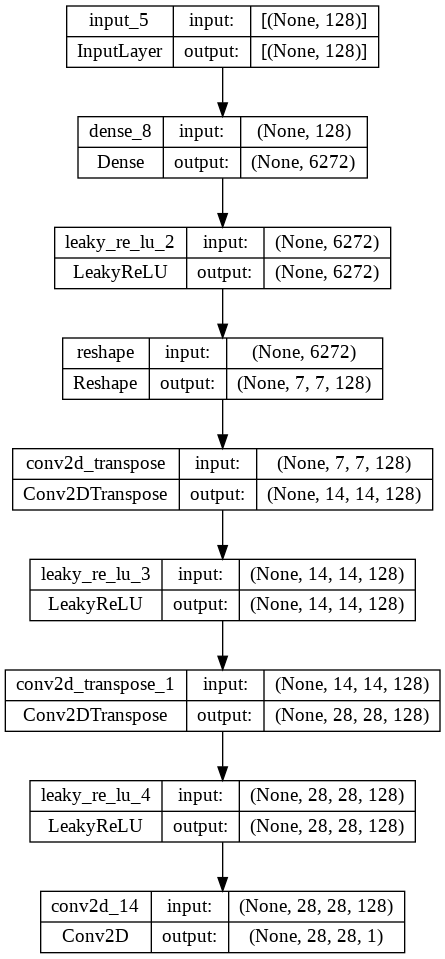

In [30]:
keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

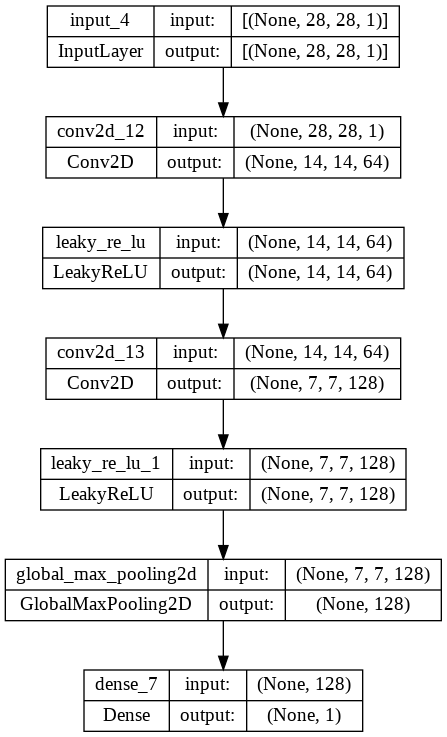

In [31]:
keras.utils.plot_model(discriminator, 'discriminator.png', show_shapes=True)

In the GAN class, we override `compile()` to use its own signature, and `train_step()`.

In [24]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images;    they are the ground truth for each batch
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0            # 1 for fake; 0 for real
        )
        # Add random noise to the labels - important trick!  (optional)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"  as Y
        misleading_labels = tf.zeros((batch_size, 1))        # genenator needs to fool discriminator by having discriminator to output 0

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}


Let's test-drive it:

In [ ]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset (-1). You will need about 20 epochs to get nice results.


#gan.fit(dataset.take(100), epochs=20)

gan.fit(dataset.take(-1), epochs=20)   # each epoch takes about 30 seconds

Epoch 1/20
1094/1094 [==============================] - 34s 30ms/step - d_loss: 0.3552 - g_loss: 2.2461
Epoch 2/20
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.5306 - g_loss: 1.2424
Epoch 3/20
1094/1094 [==============================] - 32s 30ms/step - d_loss: 0.6689 - g_loss: 0.8759
Epoch 4/20
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.6846 - g_loss: 0.8409
Epoch 5/20
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.6689 - g_loss: 0.8510
Epoch 6/20
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.6414 - g_loss: 0.9031
Epoch 7/20
1094/1094 [==============================] - 32s 30ms/step - d_loss: 0.6236 - g_loss: 0.9278
Epoch 8/20
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.5962 - g_loss: 0.9740
Epoch 9/20
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.5829 - g_loss: 1.0168
Epoch 10/20
1094/1094 [==============================] - 34s 31m

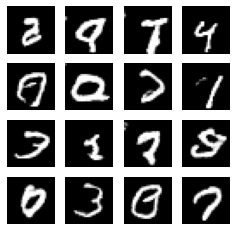

In [ ]:
num_examples_to_generate = 16

noise = tf.random.normal(shape=(num_examples_to_generate, 128))

# forward-pass through the generator 
generated_image = generator(noise, training=False)


fig = plt.figure(figsize=(4,4))

for i in range(generated_image.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(generated_image[i, :, :, 0] * 255.0, cmap='gray')
      plt.axis('off')


plt.show()